- Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?
- Попробуйте свои силы в задаче Carvana на Kaggle: https://www.kaggle.com/c/carvana-image-masking-challenge/overview. Сделайте свою реализацию U-Net на TensorFlow *Сделайте свою реализацию U-Net на TensorFlow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import keras
import cv2
from IPython.display import clear_output
from pathlib import Path
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D, LeakyReLU, Dropout, Concatenate, concatenate
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

2023-10-03 09:33:18.820487: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 09:33:19.161080: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-03 09:33:19.163763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 09:33:21.317055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class_dict = pd.read_csv(r'/media/dmitriy/Disk/Downloads/CamVid/class_dict.csv')

path_train = r'/media/dmitriy/Disk/Downloads/CamVid/train/'
path_train_labels = r'/media/dmitriy/Disk/Downloads/CamVid/train_labels/'
path_test = r'/media/dmitriy/Disk/Downloads/CamVid/test/'
path_test_labels = r'/media/dmitriy/Disk/Downloads/CamVid/test_labels/'
path_val = r'/media/dmitriy/Disk/Downloads/CamVid/val/'
path_val_labels = r'/media/dmitriy/Disk/Downloads/CamVid/val_labels/'


train_images_paths = list(Path(path_train).iterdir())

In [3]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(480, 720)

In [4]:
train_imgs_paths = list(sorted(Path(path_train).iterdir()))
train_masks_paths = list(sorted(Path(path_train_labels).iterdir()))
test_imgs_paths = list(sorted(Path(path_test).iterdir()))
test_masks_paths = list(sorted(Path(path_test_labels).iterdir()))
val_imgs_paths = list(sorted(Path(path_val).iterdir()))
val_masks_paths = list(sorted(Path(path_val_labels).iterdir()))

In [5]:
image_size = (128, 192)

In [6]:
train_images = []
train_masks = []

for i_img, i_mask in zip(train_imgs_paths, train_masks_paths):
    train_images.append(image.load_img(i_img, target_size=image_size))
    train_masks.append(image.load_img(i_mask, target_size=image_size))

In [7]:
test_images = []
test_masks = []

for i_img, i_mask in zip(test_imgs_paths, test_masks_paths):
    test_images.append(image.load_img(i_img, target_size=image_size))
    test_masks.append(image.load_img(i_mask, target_size=image_size))

In [8]:
val_images = []
val_masks = []

for i_img, i_mask in zip(val_imgs_paths, val_masks_paths):
    val_images.append(image.load_img(i_img, target_size=image_size))
    val_masks.append(image.load_img(i_mask, target_size=image_size))

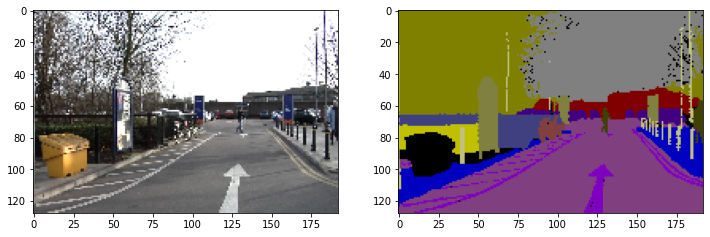

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(train_images[80].convert('RGBA'))
ax[1].imshow(train_masks[80].convert('RGBA'))

In [10]:
X_train = []

for img in train_images:
  x = image.img_to_array(img)
  X_train.append(x)

X_train = np.array(X_train)
print(X_train.shape)

(369, 128, 192, 3)


In [11]:
X_test = []

for img in test_images:
  x = image.img_to_array(img)
  X_test.append(x)

X_test = np.array(X_test)
print(X_test.shape)

(232, 128, 192, 3)


In [12]:
X_val = []

for img in val_images:
  x = image.img_to_array(img)
  X_val.append(x)

X_val = np.array(X_val)
print(X_val.shape)

(100, 128, 192, 3)


In [13]:
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [14]:
arr_col = []

for r, g, b in zip(class_dict['r'], class_dict['g'], class_dict['b']):
  arr_col.append([r, g, b]) 

In [15]:
def Color2index(y, arr_col=arr_col):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(arr_col)))
    i = 1
    for i_color in arr_col:
        ind_i = np.where(
            (y[..., 0] == i_color[0]) 
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    return y_cat, y_ind#, i-1

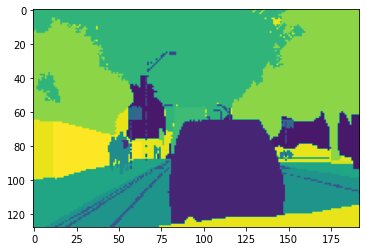

In [16]:
cat_yi, ind_yi = Color2index(image.img_to_array(train_masks[3]))
plt.imshow(ind_yi)
plt.show()  

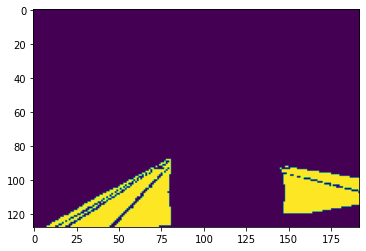

In [17]:
plt.imshow(cat_yi[..., 17])
plt.show()

In [18]:
y_train = []

for mask in train_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_train.append(y_cat)

y_train = np.array(y_train)

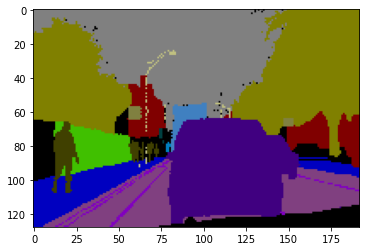

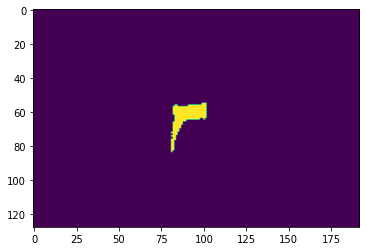

In [19]:
n = 0
plt.imshow(train_masks[n].convert('RGBA'))
plt.show()
img = y_train[n][..., 22]

plt.imshow(img)
plt.show()

In [20]:
y_test = []

for mask in test_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_test.append(y_cat)

y_test = np.array(y_test)

In [21]:
y_val = []

for mask in val_masks:
  y_cat, _ = Color2index(image.img_to_array(mask))
  y_val.append(y_cat)

y_val = np.array(y_val)

In [22]:
def unet(num_classes=32, input_shape=(128, 162, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in pre_trained_model.layers[:-5]:
        layer.trainable = False

    x = pre_trained_model.layers[13].output
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
   
    # UP 1

    # добавили перенос из VGG16
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из VGG16
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [23]:
model = unet(32, (128, 192, 3))

2023-10-03 09:34:02.595337: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


KerasTensor(type_spec=TensorSpec(shape=(None, 16, 24, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 48, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 96, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")


In [24]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [25]:
model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 192, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 192, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 96, 64)           0         ['block1_conv2[0][0]']        
                                                                                              

In [26]:
sample_image = X_test[1]
sample_mask = y_test[1]

In [27]:
def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 16]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 16])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

1/1 [==============================] - 1s 598ms/step
(1, 128, 192)


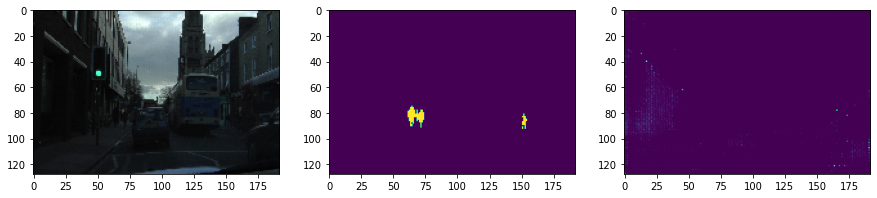

In [28]:
show_predictions(model)

1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 128, 192)


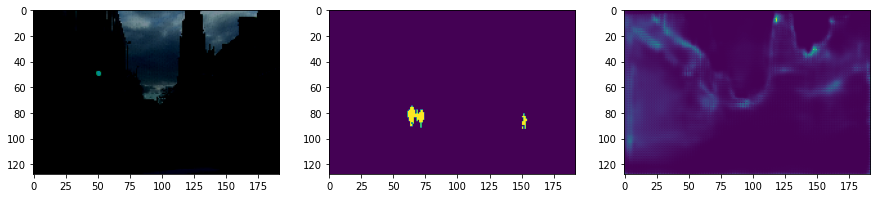


Sample Prediction after epoch 20
37/37 [==============================] - 124s 3s/step - loss: 0.3495 - dice_coef: 0.8409 - val_loss: 0.7306 - val_dice_coef: 0.7666


In [29]:
history = model.fit(preprocess_input(X_train), y_train,
                      epochs=20,
                      batch_size=10,
                      validation_data=(preprocess_input(X_test), y_test),
                      callbacks=[DisplayCallback(patience=5)])

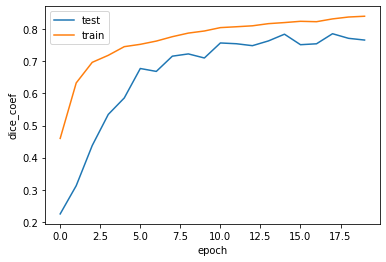

In [30]:
plt.plot(history.history['val_dice_coef'], label='test')
plt.plot(history.history['dice_coef'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [31]:
pred = model.predict(X_val)
print(pred.shape)

4/4 [==============================] - 11s 2s/step
(100, 128, 192, 32)


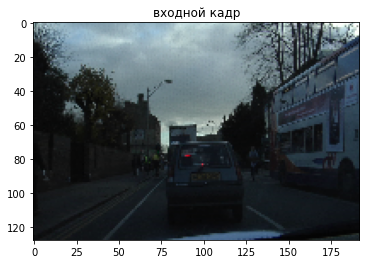

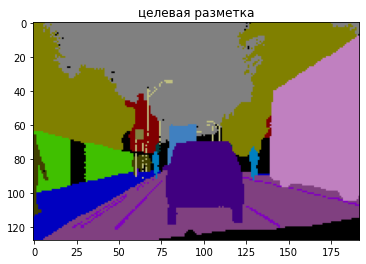

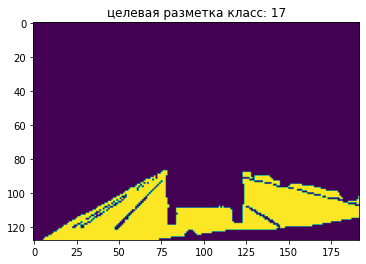

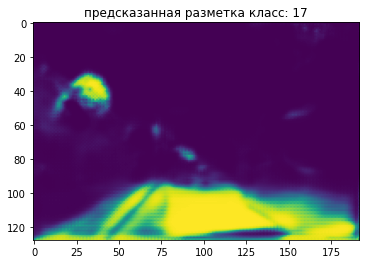

In [32]:
n = 1
class_ = 17
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n][..., class_]
plt.imshow(img)
plt.title('предсказанная разметка класс: ' + str(class_))
plt.show()

In [33]:
import tensorflow as tf
import os
import shutil
import glob
from zipfile import ZipFile
from PIL import Image

In [34]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [35]:
with ZipFile(r'/media/dmitriy/Disk/Downloads/carvana-image-masking-challenge/train.zip', 'r') as zf:
    zf.extractall(r'/media/dmitriy/Disk/Downloads/kaggle/working')

with ZipFile(r'/media/dmitriy/Disk/Downloads/carvana-image-masking-challenge/train_masks.zip', 'r') as zf:
    zf.extractall(r'/media/dmitriy/Disk/Downloads/kaggle/working')

In [36]:
img = Image.open(r'/media/dmitriy/Disk/Downloads/kaggle/working/train/151c7f2d4183_11.jpg')
print('Format:', img.format)
print('Size:', img.size)
print('Mode:', img.mode)

Format: JPEG
Size: (1918, 1280)
Mode: RGB


In [37]:
root_dir = '/media/dmitriy/Disk/Downloads/kaggle/working/'
file_path = root_dir + 'train/*.*'
file_mask_path = root_dir + 'train_masks/*.*'
image_file = sorted(glob.glob(file_path))
mask_file = sorted(glob.glob(file_mask_path))
img_dir = image_file
seg_dir = mask_file
dataset = tf.data.Dataset.from_tensor_slices((img_dir, seg_dir))


def load_image(file_path, seg_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 255.0
    seg = tf.io.read_file(seg_path)
    seg = tf.squeeze(tf.io.decode_gif(seg), axis=0)
    seg = tf.image.resize(seg, [256, 256])
    seg = tf.cast(seg, tf.float32) / 255.0
    return img, seg


dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
batch_size = 64
val_size = 0.2
val_size = int(len(img_dir) * val_size)
dataset = dataset.shuffle(buffer_size=1000)
val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

In [38]:
class Augment(keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [39]:
train_batches = (
    train_dataset
    .shuffle(1000)
    .batch(batch_size)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_batches = val_dataset.batch(batch_size)

In [40]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

2023-10-03 10:15:23.773436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 470 of 1000
2023-10-03 10:15:25.936630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


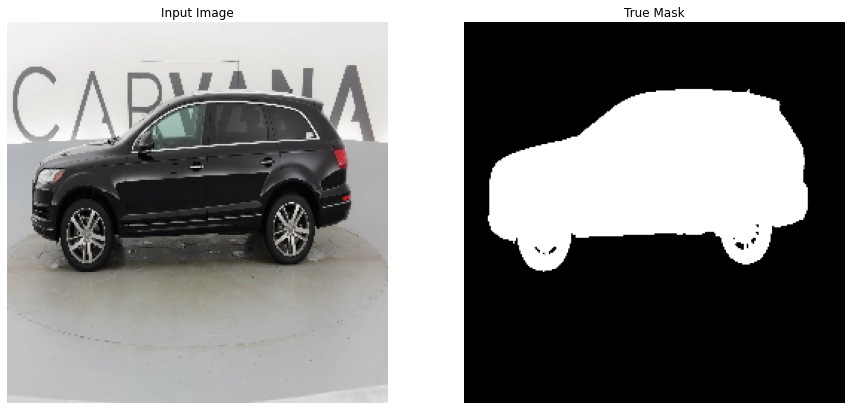

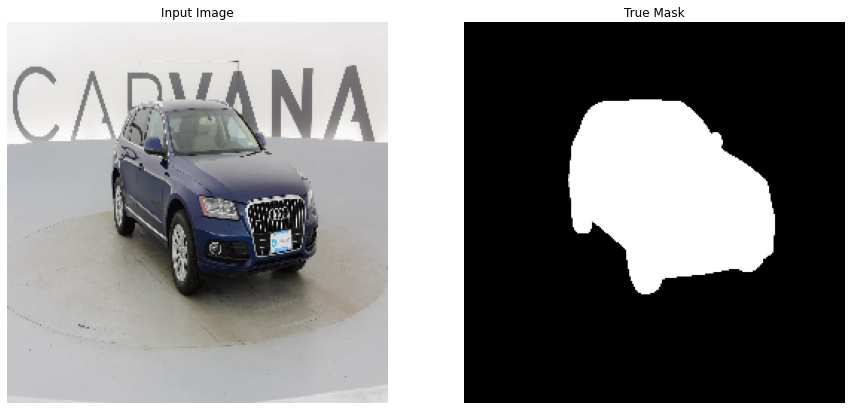

In [41]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [42]:
def encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = tf.random_normal_initializer(0.02, seed=seed)
    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same',
                     kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02, seed=seed)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same',
                              kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.3)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

# define the U-Net model
def UNet(image_shape=(256, 256, 3)):
    # weight initialization
    init = tf.random_normal_initializer(stddev=0.02, seed=seed)
    # image input
    in_image = keras.Input(shape=image_shape)
    
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = encoder_block(in_image, 64, batchnorm=False)
    e2 = encoder_block(e1, 128)
    e3 = encoder_block(e2, 256)
    e4 = encoder_block(e3, 512)
    e5 = encoder_block(e4, 512)
    e6 = encoder_block(e5, 512)
    e7 = encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    
    # decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    
    # output 
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('sigmoid')(g)
    model = keras.Model(in_image, out_image)
    return model

image_shape = (256, 256, 3)
model = UNet(image_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 128, 128, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)         0         ['conv2d_9[0][0]']            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 64, 64, 128)          131200    ['leaky_re_lu[0][0]']         
                                                                                            

In [43]:
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def iou_score(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [44]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_score, iou_score])

In [45]:
history = model.fit(train_batches, epochs=10, validation_data=val_batches)

Epoch 1/10


2023-10-03 10:15:42.774812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 423 of 1000
2023-10-03 10:15:45.033108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 968s 15s/step - loss: 0.3597 - dice_score: 0.4401 - iou_score: 0.2200 - val_loss: 0.1889 - val_dice_score: 0.6907 - val_iou_score: 0.3453
Epoch 2/10


2023-10-03 10:31:46.509983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 438 of 1000
2023-10-03 10:31:48.868269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 969s 15s/step - loss: 0.1171 - dice_score: 0.8179 - iou_score: 0.4090 - val_loss: 0.0633 - val_dice_score: 0.9041 - val_iou_score: 0.4520
Epoch 3/10


2023-10-03 10:47:55.949160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 409 of 1000
2023-10-03 10:47:58.369988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 971s 15s/step - loss: 0.0510 - dice_score: 0.9241 - iou_score: 0.4621 - val_loss: 0.0445 - val_dice_score: 0.9342 - val_iou_score: 0.4671
Epoch 4/10


2023-10-03 11:04:07.479634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 478 of 1000
2023-10-03 11:04:09.618175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 1100s 17s/step - loss: 0.0386 - dice_score: 0.9431 - iou_score: 0.4716 - val_loss: 0.0360 - val_dice_score: 0.9481 - val_iou_score: 0.4740
Epoch 5/10


2023-10-03 11:22:27.894035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 92 of 1000
2023-10-03 11:22:32.147837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 1135s 18s/step - loss: 0.0318 - dice_score: 0.9536 - iou_score: 0.4768 - val_loss: 0.0306 - val_dice_score: 0.9555 - val_iou_score: 0.4777
Epoch 6/10


2023-10-03 11:41:23.076968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-10-03 11:41:28.065733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 997s 15s/step - loss: 0.0276 - dice_score: 0.9600 - iou_score: 0.4800 - val_loss: 0.0264 - val_dice_score: 0.9616 - val_iou_score: 0.4808
Epoch 7/10


2023-10-03 11:58:00.465427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 458 of 1000
2023-10-03 11:58:02.746997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 1001s 15s/step - loss: 0.0236 - dice_score: 0.9659 - iou_score: 0.4829 - val_loss: 0.0233 - val_dice_score: 0.9662 - val_iou_score: 0.4831
Epoch 8/10


2023-10-03 12:14:42.018676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 331 of 1000
2023-10-03 12:14:45.021576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 996s 15s/step - loss: 0.0212 - dice_score: 0.9693 - iou_score: 0.4847 - val_loss: 0.0208 - val_dice_score: 0.9699 - val_iou_score: 0.4850
Epoch 9/10


2023-10-03 12:31:18.537982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 470 of 1000
2023-10-03 12:31:20.799505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 973s 15s/step - loss: 0.0202 - dice_score: 0.9710 - iou_score: 0.4855 - val_loss: 0.0207 - val_dice_score: 0.9703 - val_iou_score: 0.4852
Epoch 10/10


2023-10-03 12:47:32.080123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 487 of 1000
2023-10-03 12:47:34.167244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


64/64 [==============================] - 1018s 16s/step - loss: 0.0187 - dice_score: 0.9732 - iou_score: 0.4866 - val_loss: 0.0199 - val_dice_score: 0.9722 - val_iou_score: 0.4861


In [46]:
def show_predictions(dataset=val_batches):
  if dataset:
    for image, mask in dataset.take(5):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask[0]])

2/2 [==============================] - 6s 3s/step


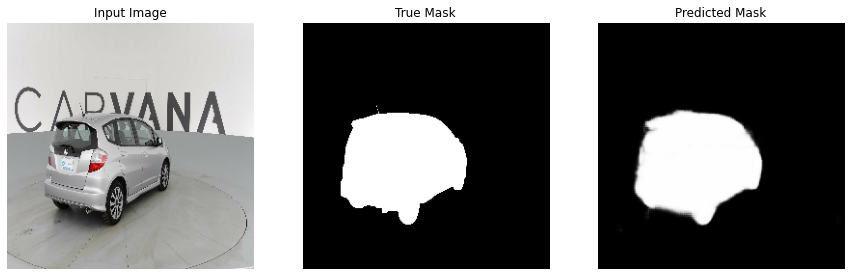

2/2 [==============================] - 6s 3s/step


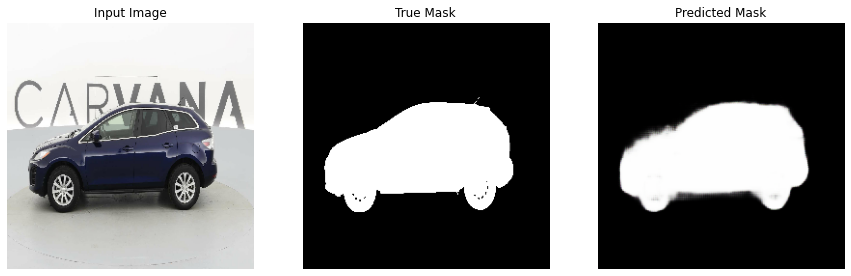

2/2 [==============================] - 6s 3s/step


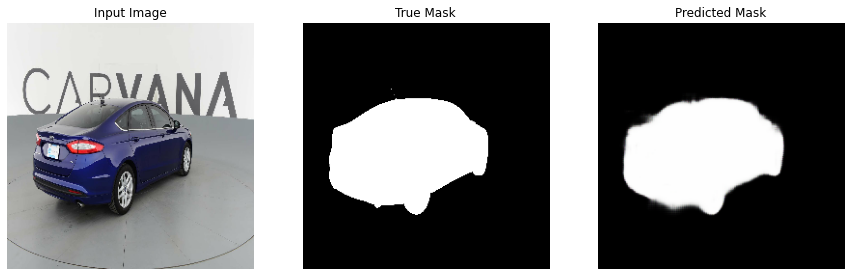

2/2 [==============================] - 6s 3s/step


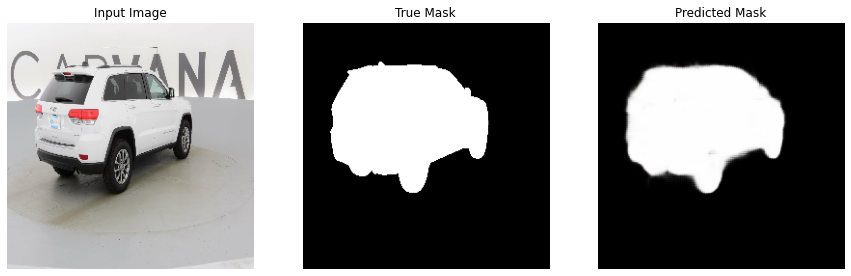

2/2 [==============================] - 6s 3s/step


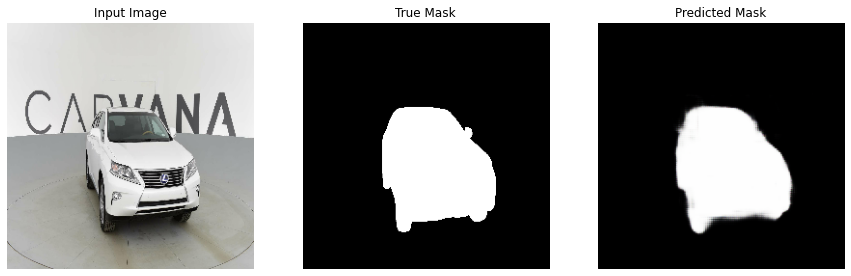

In [47]:
show_predictions()